In [3]:
# pip install opencv-python

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [6]:
def binarize(img):
    img = image.img_to_array(img, dtype='uint8')
    binarized = np.expand_dims(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2), -1)
    inverted_binary_img = ~binarized
    return inverted_binary_img

In [9]:
data_dir = 'extracted_images'
batch_size = 32
img_height = 45
img_width = 45

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=binarize)

In [11]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode="categorical",
        seed=123)

Found 217157 images belonging to 23 classes.


In [12]:
# Class names
class_names = [k for k,v in train_generator.class_indices.items()]
print(class_names)

['!', '(', ')', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '[', ']', 'b', 'div', 'sqrt', '{', '}']


In [8]:
num_classes = 23

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Input((45, 45, 1)),
    tf.keras.layers.Rescaling(1.0 / 255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 45, 45, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 43, 43, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 19, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,775 (229.59 KB)

 Trainable params: 58,775 (229.59 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are not one-hot
    metrics=['accuracy']
)

In [11]:
model.fit(
  train_generator,
  epochs=3
)

Epoch 1/3


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6787/6787 ━━━━━━━━━━━━━━━━━━━━ 492s 72ms/step - accuracy: 0.9004 - loss: 0.3565
Epoch 2/3
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 449s 66ms/step - accuracy: 0.9740 - loss: 0.0840
Epoch 3/3
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 513s 76ms/step - accuracy: 0.9815 - loss: 0.0582


In [12]:
model.save('eqn-detect-model.h5')

In [23]:
image_dir = "Test_images/"

In [24]:
def getOverlap(a, b):
     return max(0, min(a[1], b[1]) - max(a[0], b[0]))
def detect_contours(img_path):
    # Given an image path, output bounding box coordinates of an image
    input_image = cv2.imread(img_path, 0) # Load a greyscale image
 
    # Make a copy to draw bounding box
    input_image_cpy = input_image.copy()

    # Convert the grayscale image to binary (image binarization opencv python), then invert
    binarized = cv2.adaptiveThreshold(input_image_cpy,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    inverted_binary_img = ~binarized

    # Detect contours
    # hierarchy variable contains information about the relationship between each contours
    contours_list, hierarchy = cv2.findContours(inverted_binary_img,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE) # Find contours
    # Detect contours
    l = []
    for c in contours_list:
        x, y, w, h = cv2.boundingRect(c)
        l.append([x, y, w, h])
    # Check whether any overlapping rectangles. We do this in a way such that we only compare each box once with all other boxes.
    lcopy = l.copy()
    keep = []
    while len(lcopy) != 0:
        curr_x, curr_y, curr_w, curr_h = lcopy.pop(0) # Look at next box
        if curr_w * curr_h < 30: # remove very small boxes
            continue
        throw = []
        for i, (x, y, w, h) in enumerate(lcopy):
            curr_interval = [curr_x, curr_x+curr_w]
            next_interval = [x, x+w]
            if getOverlap(curr_interval, next_interval) > 1 : # more than 3 pixels overlap, this is arbitrary
                # Merge the two intervals
                new_interval_x = [min(curr_x, x), max(curr_x+curr_w, x+w)]
                new_interval_y = [min(curr_y, y), max(curr_y+curr_h, y+h)]
                newx, neww = new_interval_x[0], new_interval_x[1] - new_interval_x[0]
                newy, newh = new_interval_y[0], new_interval_y[1] - new_interval_y[0]
                curr_x, curr_y, curr_w, curr_h = newx, newy, neww, newh
                throw.append(i) # Mark this box to throw away later, since it has now been merged with current box
        for ind in sorted(throw, reverse=True): # Sort in reverse order otherwise we will pop incorrectly
            lcopy.pop(ind)
        keep.append([curr_x, curr_y, curr_w, curr_h]) # Keep the current box we are comparing against
    return keep

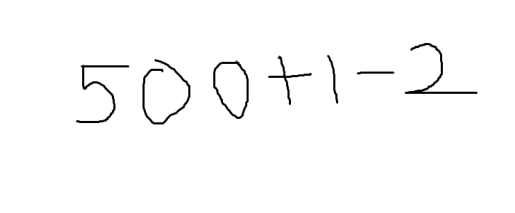

In [37]:
import matplotlib.pyplot as plt
import cv2

flag = 1  # flag = 1 for handwritten images, 0 for drawn images
IMAGE = "test9.png"
img_path = "Test_images/" + IMAGE

# Load the image using OpenCV
input_image = cv2.imread(img_path)

# Convert the image to RGB because OpenCV loads images in BGR format
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(input_image_rgb)
plt.axis('off')  # Turn off axes for a cleaner display
plt.show()


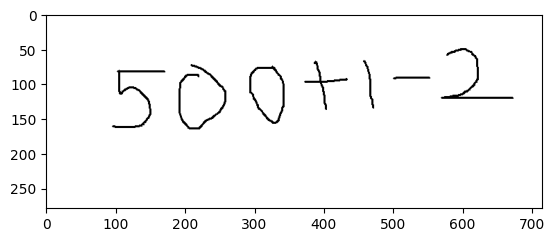

7


In [38]:
import cv2
import matplotlib.pyplot as plt

if flag == 1:
    # Read the input image in grayscale mode
    input_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if input_image is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")

    # Apply binary thresholding
    ret, bw_img = cv2.threshold(input_image, 127, 255, cv2.THRESH_BINARY)

    # Display the binary image using grayscale colormap
    plt.imshow(bw_img, cmap='gray')
    plt.show()

    # Save the binary image
    cv2.imwrite('Test_images/savedimage.jpg', bw_img)

    # Make a copy of the binary image
    input_image_cpy = bw_img.copy()

    # Call the detect_contours function
    keep = detect_contours(image_dir + 'savedimage.jpg')
    print(len(keep))
    img_path = image_dir + 'savedimage.jpg'

else:
    # Read the input image in grayscale mode
    input_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if input_image is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")
    
    # Make a copy of the input image
    input_image_cpy = input_image.copy()

    # Call the detect_contours function
    keep = detect_contours(image_dir + IMAGE)
    print(len(keep))




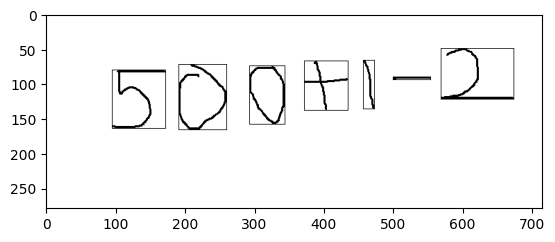

In [39]:

#Visualise how the bounding boxes look like
for (x, y, w, h) in keep:
    cv2.rectangle(input_image_cpy, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(input_image_cpy, cmap='gray')
plt.show()

In [40]:
def resize_pad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [41]:
# Load model
new_model = tf.keras.models.load_model('eqn-detect-model.h5')

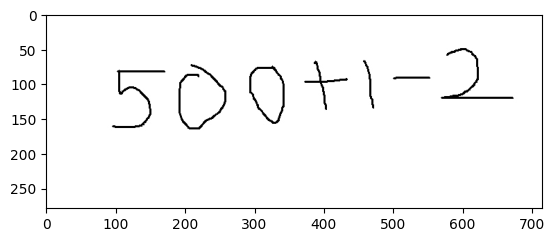

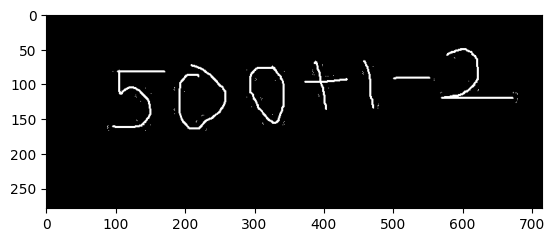

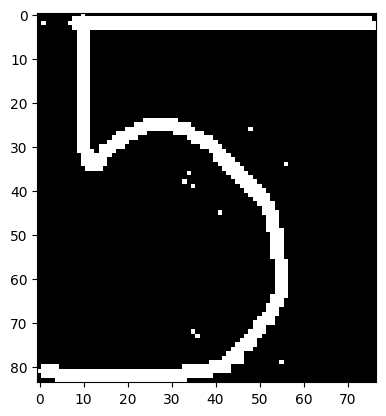

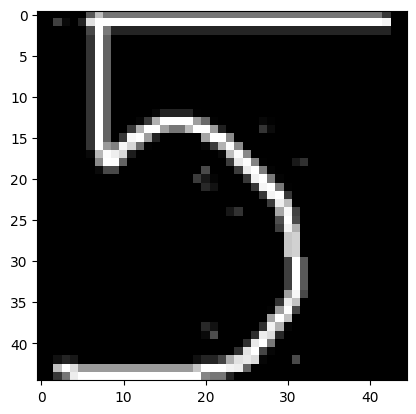

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
5


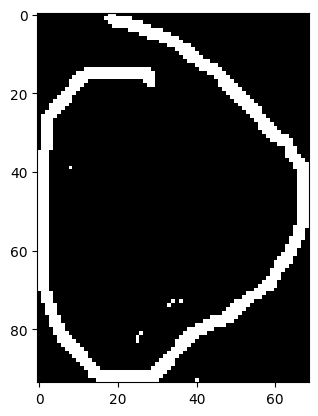

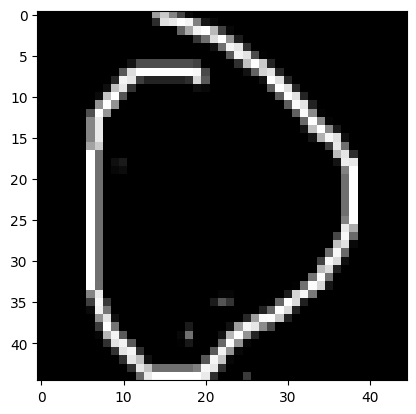

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0


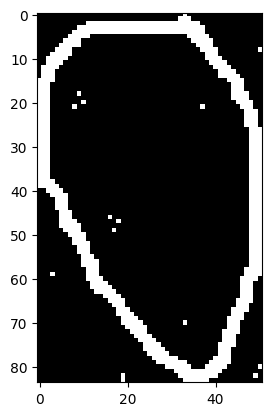

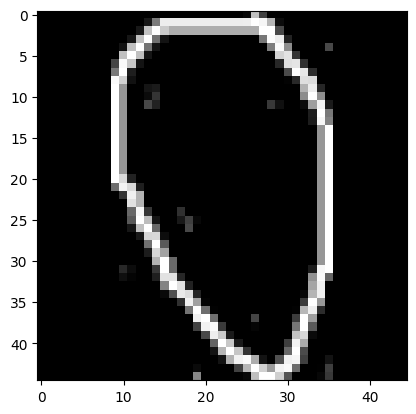

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
0


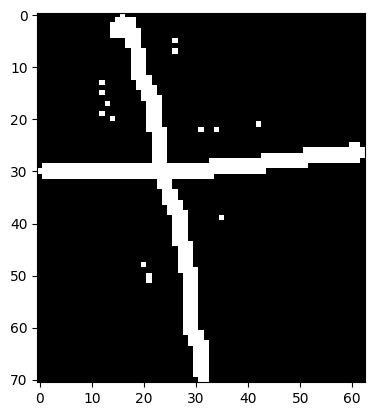

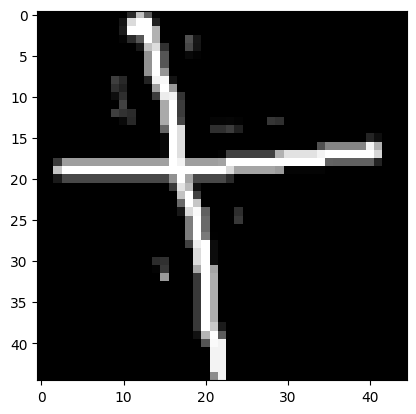

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
+


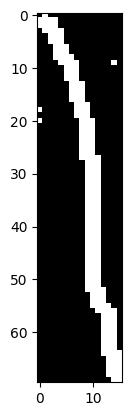

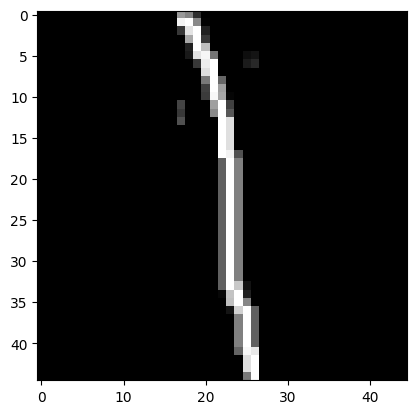

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1


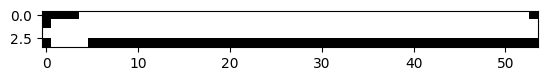

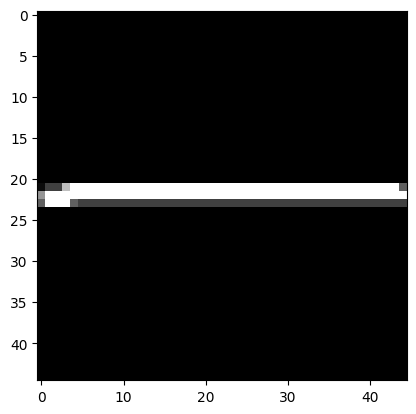

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
-


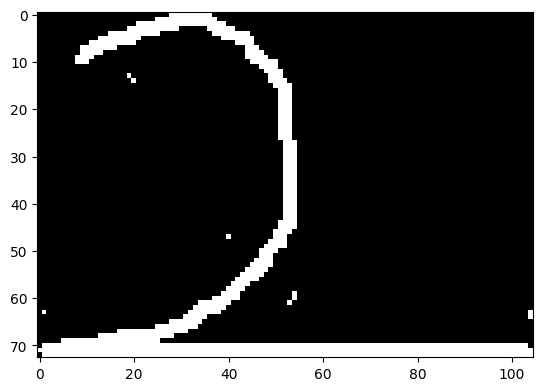

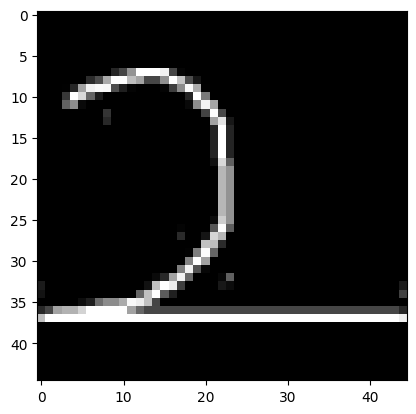

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2
Detected Equation: 500+1-2
Result: 499


In [42]:
eqn_list = []

# Binarize the input image
input_image = cv2.imread(img_path, 0)
if input_image is None:
    print("Error: Image could not be loaded.")
else:
    inverted_binary_img = binarize(input_image)
    
    # Display the original and binarized images
    plt.imshow(input_image, cmap='gray')
    plt.show()
    plt.imshow(inverted_binary_img, cmap='gray')
    plt.show()

    # Iterate over the detected contours and classify the symbols
    for (x, y, w, h) in sorted(keep, key=lambda x: x[0]):
        # Display each symbol's cropped image
        plt.imshow(inverted_binary_img[y:y+h, x:x+w], cmap='gray')
        plt.show()

        # Resize and pad the cropped image for prediction
        img = resize_pad(inverted_binary_img[y:y+h, x:x+w], (45, 45), 0)
        plt.imshow(img, cmap='gray')
        plt.show()

        # Predict the class using the model
        pred_class = class_names[np.argmax(new_model.predict(tf.expand_dims(tf.expand_dims(img, 0), -1)))]
        
        # Map recognized classes to their corresponding symbols
        if pred_class == "plus":
            pred_class = "+"
        elif pred_class == "minus":
            pred_class = "-"
        elif pred_class == "times":
            pred_class = "*"
        elif pred_class == "alpha":
            pred_class = "*"
        elif pred_class == "div":
            pred_class = "/"
        elif pred_class == "sqrt":
            pred_class = "sqrt"
        elif pred_class == "log":
            pred_class = "log"
        elif pred_class == "pi":
            pred_class = "pi"
        elif pred_class == "e":
            pred_class = "e"
        # Add any additional mappings here if needed

        eqn_list.append(pred_class)
        print(pred_class)

    # Join the detected symbols into a full equation
    eqn = "".join(eqn_list)
    print("Detected Equation:", eqn)

    # Evaluate the equation
    try:
        # Handle special cases like "sqrt" and "log" before evaluation
        eqn = eqn.replace("sqrt", "np.sqrt").replace("log", "np.log").replace("pi", "np.pi").replace("e", "np.e")
        result = eval(eqn)
        print("Result:", result)
    except Exception as e:
        print("Error evaluating equation:", e)
